# Benchmarking Results Analysis

Analysis of steering vector impact on model capabilities across standard benchmarks.

## Setup

In [1]:
import os
import json
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from pathlib import Path
import sys

## Load Data

In [2]:
LOG_DIR = "../logs"
FIG_DIR = "../outputs/figures"
DATA_DIR = "../data"

In [3]:
def extract_results(log_file):
    try:
        with open(log_file, "r") as f:
            data = json.load(f)

        # Extract benchmark name
        benchmark = data.get("eval", {}).get("task", "").split("/")[-1]
        status = data.get("status", "")
        if status != "success":
            print(f"Skipping {log_file} due to status: {status}")
            return None
        n_samples = data.get("eval", {}).get("dataset", {}).get("samples", 0)
        n_sample_ids = len(data.get("eval", {}).get("dataset", {}).get("sample_ids", 0))
        assert (
            n_samples == n_sample_ids
        ), f"Number of samples ({n_samples}) does not match number of sample IDs ({n_sample_ids})"

        # Extract multiplier directly from the path
        path_str = str(log_file)
        path_parts = path_str.split("/")

        # Find the part containing 'multiplier_X'
        for part in path_parts:
            if part.startswith("multiplier_"):
                multiplier = float(part.split("_")[1])
                break
        else:
            multiplier = None

        # Extract category from path
        category = path_parts[-3] if len(path_parts) >= 3 else None

        # Extract metrics from results
        results = data.get("results", {})
        subset = data.get("eval", {}).get("task_args", "").get("subset", "")
        metrics = {}

        if "scores" in results:
            for score in results["scores"]:
                if "metrics" in score:
                    for metric_name, metric_data in score["metrics"].items():
                        metrics[metric_name] = metric_data.get("value")

        return {
            "benchmark": benchmark,
            "subset": subset,
            "multiplier": multiplier,
            "category": category,
            "n_samples": n_samples,
            **metrics,  # Add all metrics as columns
        }

    except Exception as e:
        print(f"Error processing {log_file}: {e}")
        return None

In [4]:
extract_raw = False
if extract_raw:
    log_files = list(Path(LOG_DIR).glob("**/*.json"))
    print(f"Found {len(log_files)} log files")

    # Extract results from each file
    results = []
    for log_file in log_files:
        result = extract_results(log_file)
        if result:
            results.append(result)

    # Create DataFrame
    df = pd.DataFrame(results)
    df.to_csv(f"{DATA_DIR}/aggregated_inspect_logs.csv", index=False)

else:
    df = pd.read_csv(f"{DATA_DIR}/aggregated_inspect_logs.csv")

## Clean Categories

In [5]:
print(df["benchmark"].unique())

['xstest' 'mbpp' 'humaneval' 'mmlu_0_shot' 'ifeval' 'gpqa_diamond'
 'arc_easy' 'arc_challenge' 'truthfulqa' 'commonsense_qa' 'sycophancy'
 'gsm8k']


In [6]:
benchmark_to_category = {
    "mmlu_0_shot": "Knowledge",
    "gpqa_diamond": "Knowledge",
    "commonsense_qa": "Knowledge",
    "truthfulqa": "Knowledge",
    "arc_easy": "Reasoning",
    "arc_challenge": "Reasoning",
    "ifeval": "Instruction-Following",
    "humaneval": "Code Generation",
    "mbpp": "Code Generation",
    "gsm8k": "Math",
    "sycophancy": "Safety & Alignment",
    "xstest": "Safety & Alignment",
}

df["category"] = df["benchmark"].map(benchmark_to_category)

df

,benchmark,subset,multiplier,category,n_samples,refusal_rate,accuracy,stderr,prompt_strict_acc,prompt_strict_stderr,...,inst_strict_acc,inst_strict_stderr,inst_loose_acc,inst_loose_stderr,final_acc,final_stderr,mean,inspect_evals/confidence,inspect_evals/apologize_rate,inspect_evals/truthfulness
0,xstest,unsafe,-1.5,Safety & Alignment,200,65.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xstest,safe,-1.5,Safety & Alignment,250,0.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,xstest,safe,0.5,Safety & Alignment,250,1.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xstest,unsafe,0.5,Safety & Alignment,200,85.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,xstest,safe,-1.0,Safety & Alignment,250,0.8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,gsm8k,NaN,-1.0,Math,1319,NaN,0.932525,0.006909,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,gsm8k,NaN,-0.5,Math,1319,NaN,0.942381,0.006419,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,gsm8k,NaN,1.5,Math,1319,NaN,0.072782,0.007156,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,gsm8k,NaN,1.0,Math,1319,NaN,0.893859,0.008484,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot Overall Comparison

In [7]:
# Define colors for multipliers
multiplier_colors = {
    -1.5: "#1a237e",  # darker blue
    -1.0: "#3b4cc0",  # blue
    -0.5: "#8db0fe",  # light blue
    0.0: "#918f8f",  # neutral gray
    0.5: "#f4987a",  # light red
    1.0: "#b40426",  # red
    1.5: "#7f0000",  # darker red
}

In [8]:
def plot_benchmark_comparison(
    df,
    metric="accuracy",
    multiplier_colors=multiplier_colors,
    figsize=(16, 10),
    fig_dir=None,
):
    """
    Creates a visually appealing bar chart of benchmark performance by multiplier,
    grouped by category with proper spacing and styling. Includes sample size (N) for each benchmark.

    Args:
        df: DataFrame with benchmark data
        metric: Metric to plot (default: 'accuracy')
        figsize: Figure size (width, height) in inches
    """
    if metric not in df.columns or "stderr" not in df.columns:
        print(f"Missing {metric} or stderr in results")
        return

    # Filter only rows with the metric and stderr
    plot_df = df.dropna(subset=[metric, "stderr"]).copy()

    if len(plot_df) == 0:
        print(f"No data available for {metric} with stderr")
        return

    # Ensure category column is present
    if "category" not in plot_df.columns:
        print("Category column is missing, cannot group benchmarks")
        return

    # Make sure n_samples is available
    if "n_samples" not in plot_df.columns:
        print("n_samples column is missing, will not show sample sizes")
        has_n_samples = False
    else:
        has_n_samples = True

    # Sort by category and benchmark name for better organization
    plot_df = plot_df.sort_values(["category", "benchmark"])

    # Create a figure with increased size and resolution
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # Get unique categories and benchmarks
    categories = plot_df["category"].unique()

    # Dictionary to store benchmark positions
    benchmark_positions = {}
    benchmark_n_samples = {}  # Store n_samples for each benchmark

    # Calculate positions for each benchmark
    total_benchmarks = 0
    category_start_positions = {}
    category_end_positions = {}
    category_widths = {}

    for cat in categories:
        cat_benchmarks = plot_df[plot_df["category"] == cat]["benchmark"].unique()
        category_start_positions[cat] = total_benchmarks
        category_widths[cat] = len(cat_benchmarks)

        for i, benchmark in enumerate(cat_benchmarks):
            benchmark_positions[benchmark] = total_benchmarks + i
            # Get n_samples for this benchmark
            if has_n_samples:
                # Get all n_samples for this benchmark (may vary by multiplier)
                n_samples_values = plot_df[plot_df["benchmark"] == benchmark][
                    "n_samples"
                ].unique()
                # If multiple values, use the first one (all should be the same for a given benchmark)
                benchmark_n_samples[benchmark] = n_samples_values[0]

        total_benchmarks += len(cat_benchmarks)
        category_end_positions[cat] = total_benchmarks - 1

    # Get unique multipliers and sort them
    multipliers = sorted(plot_df["multiplier"].unique())

    # Width of each bar
    bar_width = 0.9 / len(multipliers)

    # Plot bars for each multiplier
    for i, multiplier in enumerate(multipliers):
        multiplier_df = plot_df[plot_df["multiplier"] == multiplier]

        # X positions for this multiplier's bars
        x_pos = []
        # Y values
        y_vals = []
        # Error values (95% CI = 1.96 * stderr)
        err_vals = []
        # Labels for x-axis
        x_labels = []

        for benchmark in benchmark_positions:
            # Find data for this benchmark and multiplier
            bench_data = multiplier_df[multiplier_df["benchmark"] == benchmark]

            if len(bench_data) > 0:
                x_pos.append(benchmark_positions[benchmark])
                y_vals.append(bench_data[metric].values[0])
                # Convert stderr to 95% CI
                err_vals.append(bench_data["stderr"].values[0] * 1.96)
                x_labels.append(benchmark)
            else:
                # If no data for this benchmark and multiplier, add NaN
                x_pos.append(benchmark_positions[benchmark])
                y_vals.append(np.nan)
                err_vals.append(np.nan)
                x_labels.append(benchmark)

        # Get color for this multiplier
        bar_color = multiplier_colors.get(
            multiplier, "#cccccc"
        )  # default gray if not found

        # Plot the bars with offset positions based on multiplier
        offset = (i - len(multipliers) / 2 + 0.5) * bar_width
        bars = ax.bar(
            [p + offset for p in x_pos],
            y_vals,
            bar_width,
            yerr=err_vals,
            capsize=2,
            color=bar_color,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.85,
            label=f"{multiplier}",
        )

    # Set x-axis tick positions and labels
    ax.set_xticks(list(benchmark_positions.values()))

    # Create x labels with benchmark name and n_samples
    if has_n_samples:
        x_labels_with_n = []
        for benchmark in benchmark_positions:
            n_samples = benchmark_n_samples.get(benchmark, "N/A")
            x_labels_with_n.append(f"{benchmark}\nN={n_samples}")
    else:
        x_labels_with_n = list(benchmark_positions.keys())

    ax.set_xticklabels(x_labels_with_n, rotation=45, ha="right")
    ax.tick_params(axis="both", labelsize=14)

    # Format y-axis as percentage if it's accuracy
    if metric.lower() in ["accuracy", "acc"]:
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Enhance the plot with grid, spines and proper labels
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    # Add vertical lines between categories
    for i, cat in enumerate(categories):
        if i < len(categories) - 1:
            next_cat = list(categories)[i + 1]
            div_pos = (
                category_end_positions[cat] + category_start_positions[next_cat]
            ) / 2
            ax.axvline(
                x=div_pos,
                color="black",
                linestyle=":",
                alpha=1.0,
                linewidth=2,
                zorder=2,
            )

    # Add labels and title with enhanced styling
    ax.set_ylabel(metric.capitalize(), fontsize=14, fontweight="bold")
    ax.set_title(
        f"{metric.capitalize()} by Benchmark and Multiplier",
        fontsize=16,
        fontstyle="italic",
        pad=20,
    )

    # Need to call tight_layout before we can access the right transforms
    plt.tight_layout()

    # Get the transformed positions for the category boxes
    # First, get the data coordinate range
    ylim = ax.get_ylim()
    ax.set_xlim(-0.6, total_benchmarks - 0.4)
    xlim = ax.get_xlim()

    # Calculate the bottom position for category labels
    bbox = ax.get_position()

    # Define white color for all category boxes
    box_colors = {cat: "white" for cat in categories}

    # Now add the category annotation boxes
    for i, cat in enumerate(categories):
        # Calculate positions in data coordinates
        if i == 0:
            left_edge = xlim[0]  # Start exactly at left edge of plot
        else:
            prev_cat = list(categories)[i - 1]
            left_edge = (
                category_end_positions[prev_cat] + category_start_positions[cat]
            ) / 2

        if i == len(categories) - 1:
            right_edge = xlim[1]  # End exactly at right edge of plot
        else:
            next_cat = list(categories)[i + 1]
            right_edge = (
                category_end_positions[cat] + category_start_positions[next_cat]
            ) / 2

        # Define rectangle in display coordinates
        rect_width = right_edge - left_edge
        rect_height = 0.07  # Height in figure units

        # Transform to display coordinates
        display_left = ax.transData.transform((left_edge, ylim[0]))[0]
        display_right = ax.transData.transform((right_edge, ylim[0]))[0]
        display_width = display_right - display_left

        # Convert back to figure coordinates
        fig_left = display_left / fig.dpi / fig.get_figwidth()
        fig_width = display_width / fig.dpi / fig.get_figwidth()

        # Create rectangle at the bottom of the plot
        rect = mpatches.Rectangle(
            (fig_left, bbox.y0 - rect_height - 0.225),  # (x, y) of bottom left
            fig_width,  # width
            rect_height,  # height
            transform=fig.transFigure,  # in figure coordinates
            facecolor=box_colors.get(cat, "white"),  # white fill
            edgecolor="black",
            linewidth=1,
            alpha=1.0,
            zorder=3,
            clip_on=False,
        )
        fig.add_artist(rect)

        # Add centered text in the rectangle
        fig_center_x = fig_left + fig_width / 2
        fig_center_y = bbox.y0 - rect_height / 2 - 0.225

        fig.text(
            fig_center_x,
            fig_center_y,
            cat,
            ha="center",
            va="center",
            fontsize=14,
            fontweight="bold",
            zorder=4,
        )

    # Place legend centered at the top with 7 columns

    ax.legend(
        title="Multiplier",
        fontsize=14,
        title_fontsize=16,
        frameon=False,
        facecolor="white",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.4),
        ncol=min(7, len(multipliers)),
    )

    # Adjust layout to make room for the category boxes
    plt.subplots_adjust(bottom=0.2)  # Increase bottom margin to fit the N values

    # Save
    if fig_dir:
        plt.savefig(f"{fig_dir}/accuracy_by_benchmark.pdf", bbox_inches="tight")
        print(f"Saved figure to {fig_dir}/accuracy_by_benchmark.pdf")

    plt.show()

Saved figure to ../outputs/figures/accuracy_by_benchmark.pdf


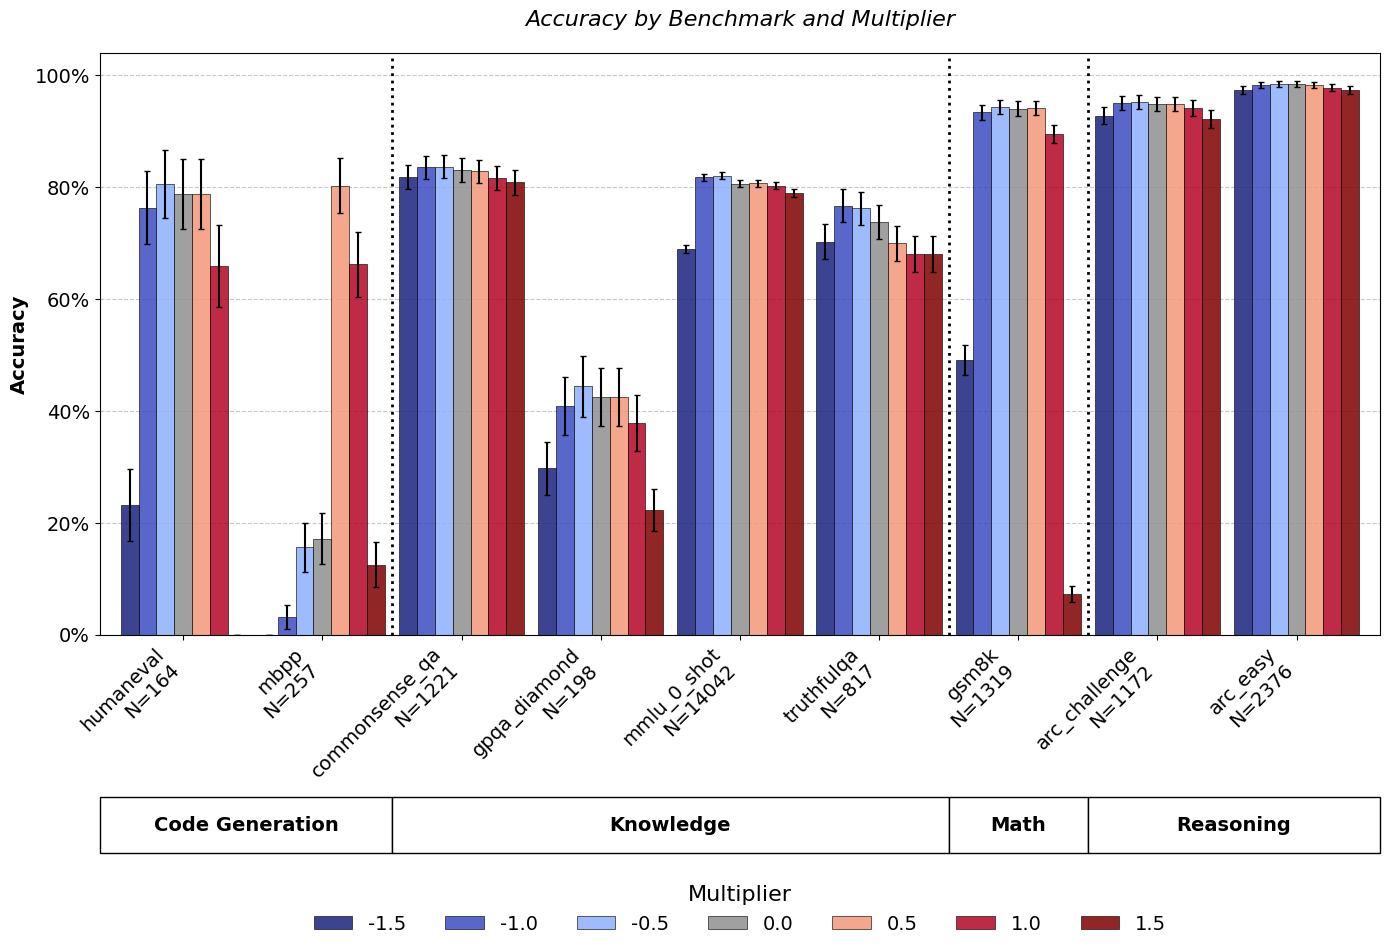

In [9]:
plot_benchmark_comparison(
    df,
    metric="accuracy",
    multiplier_colors=multiplier_colors,
    figsize=(14, 8),
    fig_dir=FIG_DIR,
)

In [10]:
def plot_ifeval_metrics(
    df, multiplier_colors=multiplier_colors, figsize=(14, 8), fig_dir=None
):
    # Filter to just the ifeval benchmark
    ifeval_df = df[df["benchmark"] == "ifeval"].copy()

    if len(ifeval_df) == 0:
        print("No data found for benchmark: ifeval")
        return

    # Define pairs of metrics and their corresponding stderr columns
    metric_pairs = [
        ("prompt_strict_acc", "prompt_strict_stderr"),
        ("prompt_loose_acc", "prompt_loose_stderr"),
        ("inst_strict_acc", "inst_strict_stderr"),
        ("inst_loose_acc", "inst_loose_stderr"),
        ("final_acc", "final_stderr"),
    ]

    # Keep only the pairs where both columns exist
    valid_pairs = []
    for acc_col, stderr_col in metric_pairs:
        if acc_col in ifeval_df.columns and stderr_col in ifeval_df.columns:
            valid_pairs.append((acc_col, stderr_col))

    if not valid_pairs:
        print("No valid metric/stderr pairs found for ifeval")
        return

    # Reshape data for plotting
    plot_data = []

    for _, row in ifeval_df.iterrows():
        for acc_col, stderr_col in valid_pairs:
            if pd.notna(row[acc_col]) and pd.notna(row[stderr_col]):
                plot_data.append(
                    {
                        "metric": acc_col.replace(
                            "_acc", ""
                        ),  # Clean up the metric name
                        "multiplier": row["multiplier"],
                        "value": row[acc_col],
                        "stderr": row[stderr_col],
                    }
                )

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Only plot if we have data
    if len(plot_df) == 0:
        print("No usable metric data available for ifeval")
        return

    # Create pivot tables
    pivot = plot_df.pivot_table(index="metric", columns="multiplier", values="value")

    stderr_pivot = plot_df.pivot_table(
        index="metric", columns="multiplier", values="stderr"
    )

    # Create a new figure with increased size and dpi
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # Get unique multipliers and sort them
    multipliers = sorted(plot_df["multiplier"].unique())

    # Width of each bar
    bar_width = 0.8 / len(multipliers)

    # Plot bars for each multiplier
    for i, multiplier in enumerate(multipliers):
        multiplier_data = pivot.loc[:, multiplier]
        stderr_data = stderr_pivot.loc[:, multiplier]

        # X positions for this multiplier's bars
        x_pos = np.arange(len(pivot.index))
        offset = (i - len(multipliers) / 2 + 0.5) * bar_width

        # Get color for this multiplier
        bar_color = multiplier_colors.get(
            multiplier, "#cccccc"
        )  # default gray if not found

        # Plot the bars with 95% CI error bars
        bars = ax.bar(
            x_pos + offset,
            multiplier_data,
            bar_width,
            yerr=stderr_data * 1.96,  # Convert to 95% CI
            capsize=4,
            color=bar_color,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.85,
            label=f"{multiplier}",
        )

    # Format y-axis as percentage
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Enhance the plot with grid, spines and proper labels
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    # Set x-axis tick positions and labels
    ax.set_xticks(np.arange(len(pivot.index)))

    # Make metric names more readable
    readable_metrics = {
        "prompt_strict": "Prompt Strict",
        "prompt_loose": "Prompt Loose",
        "inst_strict": "Instruction Strict",
        "inst_loose": "Instruction Loose",
        "final": "Final",
    }

    metric_labels = [readable_metrics.get(m, m) for m in pivot.index]
    ax.set_xticklabels(metric_labels, rotation=0, ha="center")
    ax.tick_params(axis="both", labelsize=14)

    # Add labels and title with enhanced styling
    ax.set_xlabel("Metric", fontsize=14, fontweight="bold")
    ax.set_ylabel("Accuracy", fontsize=14, fontweight="bold")
    ax.set_title(
        "IFEval Metrics by Multiplier", fontsize=16, fontstyle="italic", pad=20
    )

    # Place legend centered at the top with 7 columns
    ax.legend(
        title="Multiplier",
        fontsize=14,
        title_fontsize=16,
        frameon=False,
        facecolor="white",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=7,
        columnspacing=1,
    )

    # Set y-axis limit to start from 0 and add a little headroom at the top
    ax.set_ylim(0, min(1.0, pivot.values.max() * 1.1))

    # Make sure all elements fit
    plt.tight_layout()

    # Save
    if fig_dir:
        plt.savefig(f"{fig_dir}/ifeval_metrics_by_multiplier.pdf", bbox_inches="tight")
        print(f"Saved figure to {fig_dir}/ifeval_metrics_by_multiplier.pdf")

    plt.show()

Saved figure to ../outputs/figures/ifeval_metrics_by_multiplier.pdf


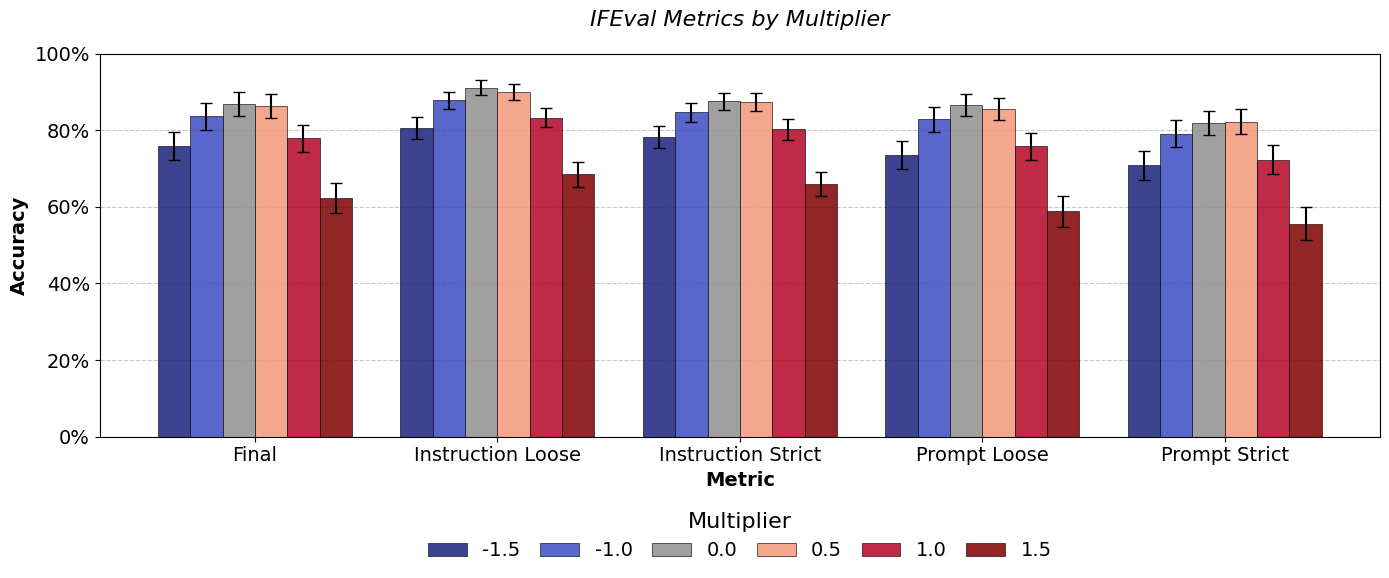

In [11]:
# Plot metrics for ifeval
if "ifeval" in df["benchmark"].values:
    plot_ifeval_metrics(df, figsize=(14, 6), fig_dir=FIG_DIR)

In [12]:
def plot_sycophancy_metrics(
    df, multiplier_colors=multiplier_colors, figsize=(14, 8), fig_dir=None
):
    # Filter to just the sycophancy benchmark
    sycophancy_df = df[df["benchmark"] == "sycophancy"].copy()

    if len(sycophancy_df) == 0:
        print("No data found for benchmark: sycophancy")
        return

    # Get all metric columns (exclude non-metric columns)
    non_metrics = ["benchmark", "multiplier", "category", "stderr", "n_samples"]
    metric_columns = [
        col
        for col in sycophancy_df.columns
        if col not in non_metrics and not pd.isna(sycophancy_df[col]).all()
    ]

    # Reshape data for plotting
    plot_data = []

    for _, row in sycophancy_df.iterrows():
        for metric in metric_columns:
            if pd.notna(row[metric]):
                # Convert the value to float to ensure numeric type
                try:
                    value = float(row[metric])
                    # Only include stderr for the 'mean' metric
                    stderr_value = (
                        float(row["stderr"])
                        if metric == "mean"
                        and "stderr" in sycophancy_df.columns
                        and pd.notna(row["stderr"])
                        else None
                    )

                    plot_data.append(
                        {
                            "metric": metric,
                            "multiplier": row["multiplier"],
                            "value": value,
                            "stderr": stderr_value,
                        }
                    )
                except (ValueError, TypeError):
                    print(
                        f"Warning: Could not convert value '{row[metric]}' for metric '{metric}' to float. Skipping."
                    )
                    continue

    # Convert to DataFrame
    plot_df = pd.DataFrame(plot_data)

    # Only plot if we have data
    if len(plot_df) == 0:
        print("No metric data available for sycophancy")
        return

    # Create pivot tables for value - explicitly specify aggfunc to avoid default mean on object types
    pivot = plot_df.pivot_table(
        index="metric",
        columns="multiplier",
        values="value",
        aggfunc="first",  # Use 'first' instead of default 'mean' to avoid aggregation issues
    )

    # Preferred order of metrics (if present)
    preferred_order = [
        "mean",
        "inspect_evals/confidence",
        "inspect_evals/apologize_rate",
        "inspect_evals/truthfulness",
    ]

    # Reorder the pivot table index
    ordered_metrics = [m for m in preferred_order if m in pivot.index]
    other_metrics = [m for m in pivot.index if m not in preferred_order]
    new_order = ordered_metrics + other_metrics
    pivot = pivot.reindex(new_order)

    # Create pivot for stderr (only for 'mean')
    stderr_df = plot_df.dropna(subset=["stderr"])
    stderr_pivot = None
    if len(stderr_df) > 0:
        stderr_pivot = stderr_df.pivot_table(
            index="metric",
            columns="multiplier",
            values="stderr",
            aggfunc="first",  # Use 'first' instead of default 'mean'
        )
        # Add standard err from mean
        for metric in pivot.index:
            if metric != "mean" and metric in stderr_pivot.index:
                stderr_pivot.loc[metric, :] = 0

    # Create a new figure with increased size and dpi
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # Get unique multipliers and sort them
    multipliers = sorted(plot_df["multiplier"].unique())

    # Width of each bar
    bar_width = 0.8 / len(multipliers)

    # Plot bars for each multiplier
    for i, multiplier in enumerate(multipliers):
        if multiplier not in pivot.columns:
            continue

        multiplier_data = pivot.loc[:, multiplier]

        # X positions for this multiplier's bars
        x_pos = np.arange(len(pivot.index))
        offset = (i - len(multipliers) / 2 + 0.5) * bar_width

        # Get stderr data if available
        if stderr_pivot is not None and multiplier in stderr_pivot.columns:
            stderr_data = stderr_pivot.loc[:, multiplier] * 1.96  # Convert to 95% CI
        else:
            stderr_data = np.zeros(len(pivot.index))

        # Get color for this multiplier
        bar_color = multiplier_colors.get(
            multiplier, "#cccccc"
        )  # default gray if not found

        # Plot the bars
        bars = ax.bar(
            x_pos + offset,
            multiplier_data,
            bar_width,
            yerr=stderr_data,
            capsize=4,
            color=bar_color,
            edgecolor="black",
            linewidth=0.5,
            alpha=0.85,
            label=f"{multiplier}",
        )

    # Enhance the plot with grid, spines and proper labels
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    # Set x-axis tick positions and labels
    ax.set_xticks(np.arange(len(pivot.index)))

    # Make metric names more readable
    readable_metrics = {
        "mean": "Mean",
        "inspect_evals/confidence": "Confidence",
        "inspect_evals/apologize_rate": "Apologize Rate",
        "inspect_evals/truthfulness": "Truthfulness",
    }

    metric_labels = [readable_metrics.get(m, m) for m in pivot.index]
    ax.set_xticklabels(metric_labels, rotation=0, ha="center")
    ax.tick_params(axis="both", labelsize=14)

    # Add labels and title with enhanced styling
    ax.set_xlabel("Metric", fontsize=14, fontweight="bold")
    ax.set_ylabel("Value", fontsize=14, fontweight="bold")
    ax.set_title(
        "Sycophancy Metrics by Multiplier", fontsize=16, fontstyle="italic", pad=20
    )

    # Place legend centered at the top with 7 columns
    ax.legend(
        title="Multiplier",
        fontsize=14,
        title_fontsize=16,
        frameon=False,
        facecolor="white",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=min(7, len(multipliers)),
        columnspacing=1,
    )

    # Set y-axis limit to start from 0 and add a little headroom at the top
    max_value = pivot.values.max()
    ax.set_ylim(0, min(1.0, max_value * 1.3) if not pd.isna(max_value) else 1.0)

    # Format y-axis as percentage for metrics that represent percentages
    import matplotlib.ticker as mtick

    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Make sure all elements fit
    plt.tight_layout()

    # Save
    if fig_dir:
        plt.savefig(
            f"{fig_dir}/sycophancy_metrics_by_multiplier.pdf", bbox_inches="tight"
        )
        print(f"Saved figure to {fig_dir}/sycophancy_metrics_by_multiplier.pdf")

    plt.show()

In [13]:
## Summary Tables

In [14]:
def plot_xstest_subsets(
    df,
    metric="refusal_rate",
    stderr_column=None,
    multiplier_colors=multiplier_colors,
    figsize=(14, 8),
    fig_dir=None,
):
    """
    Plot XSTest results with safe/unsafe subsets on the x-axis and different multipliers as grouped bars.

    Args:
        df: DataFrame containing XSTest results
        metric: The metric to plot (default: 'refusal_rate')
        stderr_column: The standard error column (default: None)
        multiplier_colors: Dictionary mapping multipliers to colors
        figsize: Figure size as (width, height)

    Returns:
        Figure and axes objects
    """
    # Filter for xstest data only
    xstest_df = df[df["benchmark"].str.startswith("xstest")].copy()

    if len(xstest_df) == 0:
        print("No data found for XSTest")
        return None, None

    # Extract subset from benchmark column if needed
    if "subset" not in xstest_df.columns:
        xstest_df["subset"] = xstest_df["benchmark"].str.replace("xstest", "")

    # Create pivot table with subsets and multipliers
    pivot = pd.pivot_table(
        xstest_df, values=metric, index="subset", columns="multiplier"
    )

    # Create stderr pivot if available
    stderr_pivot = None
    if stderr_column is not None and stderr_column in xstest_df.columns:
        stderr_pivot = pd.pivot_table(
            xstest_df, values=stderr_column, index="subset", columns="multiplier"
        )

    # Create a new figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)

    # Get unique multipliers and sort them
    multipliers = sorted(xstest_df["multiplier"].unique())

    # Width of each bar
    bar_width = 0.8 / len(multipliers)

    # Plot bars for each multiplier
    for i, multiplier in enumerate(multipliers):
        if multiplier in pivot.columns:
            multiplier_data = pivot[multiplier]

            # X positions for this multiplier's bars
            x_pos = np.arange(len(pivot.index))
            offset = (i - len(multipliers) / 2 + 0.5) * bar_width

            # Get stderr data if available and convert to 95% CI
            stderr_data = None
            if stderr_pivot is not None and multiplier in stderr_pivot.columns:
                stderr_data = stderr_pivot[multiplier] * 1.96  # Convert to 95% CI

            # Get color for this multiplier
            bar_color = multiplier_colors.get(
                multiplier, "#cccccc"
            )  # default gray if not found

            # Plot the bars
            bars = ax.bar(
                x_pos + offset,
                multiplier_data,
                bar_width,
                yerr=stderr_data,
                capsize=4,
                color=bar_color,
                edgecolor="black",
                linewidth=0.5,
                alpha=0.85,
                label=f"{multiplier}",
            )

    # Format y-axis as percentage
    # ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    # Enhance the plot with grid, spines and proper labels
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    # Set x-axis tick positions and labels
    ax.set_xticks(np.arange(len(pivot.index)))

    # Make subset names more readable
    readable_subsets = {"safe": "Safe Content", "unsafe": "Unsafe Content"}

    subset_labels = [readable_subsets.get(s, s) for s in pivot.index]
    ax.set_xticklabels(subset_labels, rotation=0, ha="center", fontsize=12)
    ax.tick_params(axis="both", labelsize=14)

    # Add labels and title with enhanced styling
    ax.set_xlabel("Content Type", fontsize=14, fontweight="bold")

    # Make metric names more readable for y-axis label
    metric_labels = {
        "refusal_rate": "Refusal Rate",
        "pass_rate": "Pass Rate",
        "failure_rate": "Failure Rate",
        "accuracy": "Accuracy",
    }

    y_label = metric_labels.get(metric, metric.replace("_", " ").title())
    ax.set_ylabel(y_label, fontsize=14, fontweight="bold")
    ax.set_title(
        f"XSTest: {y_label} by Steering Vector Multiplier",
        fontsize=16,
        fontstyle="italic",
        pad=20,
    )

    # Place legend centered at the top with multiple columns
    ncols = min(7, len(multipliers))
    ax.legend(
        title="Multiplier",
        fontsize=14,
        title_fontsize=16,
        frameon=False,
        facecolor="white",
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=ncols,
        columnspacing=1,
    )

    # Set y-axis limit to start from 0 and add a little headroom at the top
    max_value = pivot.max().max()
    # ax.set_ylim(0, min(1.0, max_value * 1.2 if max_value > 0 else 0.1))

    # Make sure all elements fit
    plt.tight_layout()

    # Save
    if fig_dir:
        plt.savefig(f"{fig_dir}/xstest_by_multiplier.pdf", bbox_inches="tight")
        print(f"Saved figure to {fig_dir}/xstest_by_multiplier.pdf")

    plt.show()

Saved figure to ../outputs/figures/xstest_by_multiplier.pdf


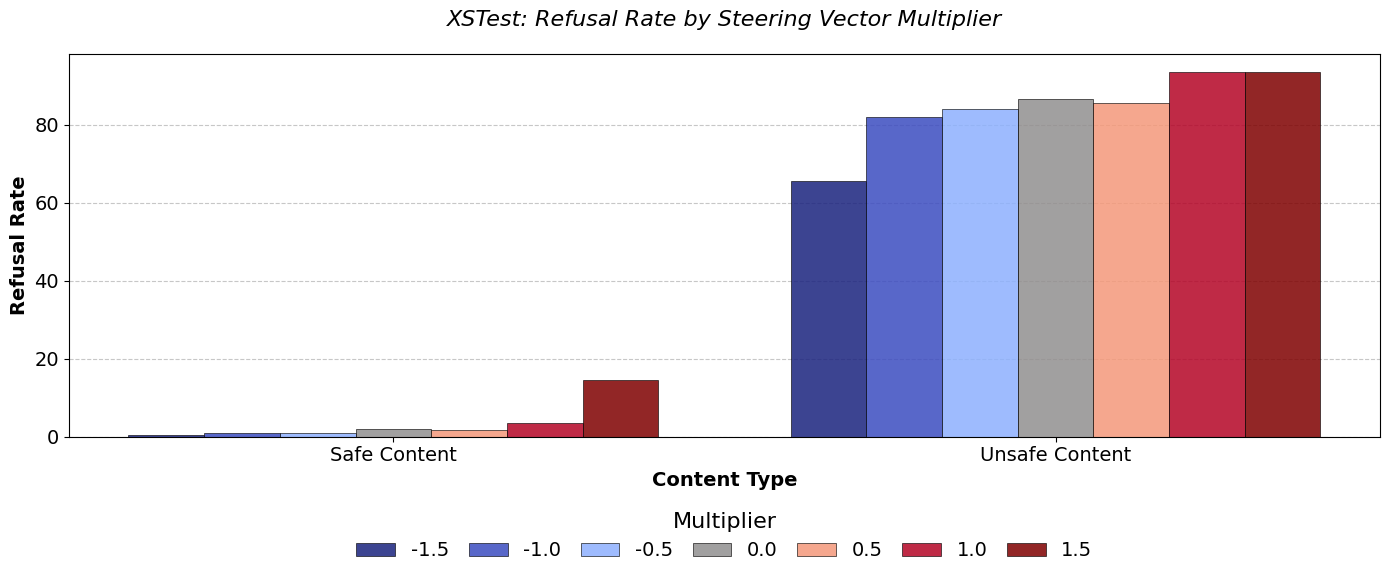

In [15]:
plot_xstest_subsets(
    df,
    metric="refusal_rate",
    stderr_column="refusal_stderr",
    figsize=(14, 6),
    fig_dir=FIG_DIR,
)

## Summarise Results

In [16]:
def print_all_benchmark_results(df):
    """
    Print detailed results for all benchmarks, organized by type.

    Args:
        df: DataFrame with benchmark data
    """
    print(f"\n{'='*100}")
    print("BENCHMARK RESULTS SUMMARY")
    print(f"{'='*100}\n")

    # Define benchmark categories
    standard_benchmarks = [
        "mmlu_0_shot",
        "gpqa_diamond",
        "commonsense_qa",
        "truthfulqa",
        "arc_easy",
        "arc_challenge",
        "humaneval",
        "mbpp",
        "gsm8k",
    ]

    # 1. Standard Benchmarks (Accuracy)
    print(f"\n{'-'*100}")
    print("STANDARD BENCHMARKS - ACCURACY")
    print(f"{'-'*100}\n")

    for benchmark in standard_benchmarks:
        bench_data = df[df["benchmark"] == benchmark].copy()
        if len(bench_data) == 0:
            continue

        bench_data = bench_data.sort_values("multiplier")

        # Get n_samples if available
        n_samples = (
            bench_data["n_samples"].iloc[0]
            if "n_samples" in bench_data.columns
            else "N/A"
        )

        print(f"{benchmark.upper()} (N={n_samples}):")
        for _, row in bench_data.iterrows():
            if pd.notna(row.get("accuracy")):
                multiplier = row["multiplier"]
                accuracy = row["accuracy"]
                stderr = row.get("stderr", 0)
                ci_95 = stderr * 1.96
                print(
                    f"  Multiplier {multiplier:>5.1f}: {accuracy:>7.2%} ± {ci_95:>6.2%}"
                )
        print()

    # 2. IFEval Metrics
    print(f"\n{'-'*100}")
    print("IFEVAL METRICS")
    print(f"{'-'*100}\n")

    ifeval_data = df[df["benchmark"] == "ifeval"].copy()
    if len(ifeval_data) > 0:
        ifeval_data = ifeval_data.sort_values("multiplier")

        # Get n_samples if available
        n_samples = (
            ifeval_data["n_samples"].iloc[0]
            if "n_samples" in ifeval_data.columns
            else "N/A"
        )
        print(f"IFEVAL (N={n_samples}):\n")

        metric_pairs = [
            ("prompt_strict_acc", "prompt_strict_stderr", "Prompt Strict"),
            ("prompt_loose_acc", "prompt_loose_stderr", "Prompt Loose"),
            ("inst_strict_acc", "inst_strict_stderr", "Instruction Strict"),
            ("inst_loose_acc", "inst_loose_stderr", "Instruction Loose"),
            ("final_acc", "final_stderr", "Final"),
        ]

        for multiplier in sorted(ifeval_data["multiplier"].unique()):
            mult_data = ifeval_data[ifeval_data["multiplier"] == multiplier].iloc[0]
            print(f"  Multiplier {multiplier:>5.1f}:")

            for acc_col, stderr_col, label in metric_pairs:
                if acc_col in mult_data and pd.notna(mult_data[acc_col]):
                    acc = mult_data[acc_col]
                    stderr = mult_data.get(stderr_col, 0)
                    if pd.notna(stderr):
                        ci_95 = stderr * 1.96
                        print(f"    {label:<20}: {acc:>7.2%} ± {ci_95:>6.2%}")
                    else:
                        print(f"    {label:<20}: {acc:>7.2%}")
            print()

    # 3. Sycophancy Metrics
    print(f"\n{'-'*100}")
    print("SYCOPHANCY METRICS")
    print(f"{'-'*100}\n")

    sycophancy_data = df[df["benchmark"] == "sycophancy"].copy()
    if len(sycophancy_data) > 0:
        sycophancy_data = sycophancy_data.sort_values("multiplier")

        # Get n_samples if available
        n_samples = (
            sycophancy_data["n_samples"].iloc[0]
            if "n_samples" in sycophancy_data.columns
            else "N/A"
        )
        print(f"SYCOPHANCY (N={n_samples}):\n")

        metric_info = [
            ("mean", "stderr", "Mean Score"),
            ("inspect_evals/confidence", None, "Confidence"),
            ("inspect_evals/apologize_rate", None, "Apologize Rate"),
            ("inspect_evals/truthfulness", None, "Truthfulness"),
        ]

        for multiplier in sorted(sycophancy_data["multiplier"].unique()):
            mult_data = sycophancy_data[
                sycophancy_data["multiplier"] == multiplier
            ].iloc[0]
            print(f"  Multiplier {multiplier:>5.1f}:")

            for metric_col, stderr_col, label in metric_info:
                if metric_col in mult_data and pd.notna(mult_data[metric_col]):
                    value = mult_data[metric_col]
                    if (
                        stderr_col
                        and stderr_col in mult_data
                        and pd.notna(mult_data[stderr_col])
                    ):
                        stderr = mult_data[stderr_col]
                        ci_95 = stderr * 1.96
                        print(f"    {label:<20}: {value:>7.2%} ± {ci_95:>6.2%}")
                    else:
                        print(f"    {label:<20}: {value:>7.2%}")
            print()

    # 4. XSTest Metrics
    print(f"\n{'-'*100}")
    print("XSTEST METRICS - REFUSAL RATE")
    print(f"{'-'*100}\n")

    xstest_data = df[df["benchmark"].str.startswith("xstest")].copy()
    if len(xstest_data) > 0:
        # Extract subset from benchmark column if needed
        if "subset" not in xstest_data.columns:
            xstest_data["subset"] = xstest_data["benchmark"].str.replace("xstest", "")

        xstest_data = xstest_data.sort_values(["subset", "multiplier"])

        for subset in sorted(xstest_data["subset"].unique()):
            subset_data = xstest_data[xstest_data["subset"] == subset]

            # Get n_samples if available
            n_samples = (
                subset_data["n_samples"].iloc[0]
                if "n_samples" in subset_data.columns
                else "N/A"
            )

            subset_label = "Safe Content" if subset == "safe" else "Unsafe Content"
            print(f"XSTEST - {subset_label.upper()} (N={n_samples}):")

            for _, row in subset_data.iterrows():
                if pd.notna(row.get("refusal_rate")):
                    multiplier = row["multiplier"]
                    refusal_rate = row["refusal_rate"]
                    print(f"  Multiplier {multiplier:>5.1f}: {refusal_rate:>7.2%}")
            print()

    print(f"{'='*100}\n")

In [17]:
print_all_benchmark_results(df)


BENCHMARK RESULTS SUMMARY


----------------------------------------------------------------------------------------------------
STANDARD BENCHMARKS - ACCURACY
----------------------------------------------------------------------------------------------------

MMLU_0_SHOT (N=14042):
  Multiplier  -1.5:  68.89% ±  0.77%
  Multiplier  -1.0:  81.67% ±  0.64%
  Multiplier  -0.5:  81.95% ±  0.64%
  Multiplier   0.0:  80.54% ±  0.65%
  Multiplier   0.5:  80.59% ±  0.65%
  Multiplier   1.0:  80.15% ±  0.66%
  Multiplier   1.5:  78.83% ±  0.68%

GPQA_DIAMOND (N=198):
  Multiplier  -1.5:  29.67% ±  4.79%
  Multiplier  -1.0:  40.78% ±  5.13%
  Multiplier  -0.5:  44.32% ±  5.51%
  Multiplier   0.0:  42.42% ±  5.19%
  Multiplier   0.5:  42.42% ±  5.19%
  Multiplier   1.0:  37.75% ±  5.00%
  Multiplier   1.5:  22.22% ±  3.76%

COMMONSENSE_QA (N=1221):
  Multiplier  -1.5:  81.74% ±  2.17%
  Multiplier  -1.0:  83.46% ±  2.09%
  Multiplier  -0.5:  83.54% ±  2.08%
  Multiplier   0.0:  82.96% ±  2.11%